# E0102 - Measuring Dust Production with New Herschel Data

In [4]:
from astropy.io import fits
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.wcs import WCS
import cv2
import scipy.ndimage
from glob import glob
from astropy.convolution import convolve_fft
from IPython.display import Audio, display, HTML, Video, Markdown
import matplotlib.animation as animation
from Mask_Handling import *
from Diffusion import *
from Misc import *
%matplotlib inline

## Spitzer and Herschel Infrared Images at 24, 70, 100 and 160 microns.

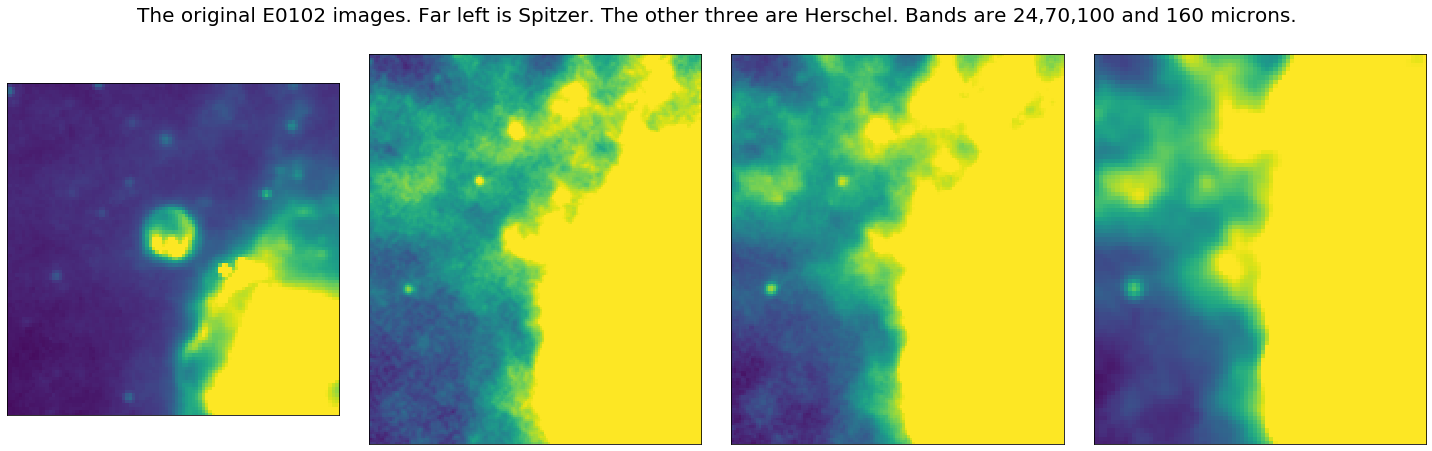

In [13]:
# File Handling
infrared_file = ["Original_Files/Infrared/" + file for file in ["n76crop_smcsage_24.fits","e0102_pacs70_new.fits","e0102_pacs100_new.fits","e0102_pacs160_new.fits"]]

# Set plot dimensions by first image and transform coordinates to the other images
xdim = [160,260]
ydim = [100,200]
ra,dec = to_world(infrared_file[0],xdim,ydim)
dim = np.array([to_pix(file,ra,dec) for file in infrared_file])

# Get a region to sample the min,max of the image.
d = [fits.open(file)[0].data[int(dim[i,0,0]):int(dim[i,0,1]),int(dim[i,1,0]):int(dim[i,1,1])] for i,file in enumerate(infrared_file)]

f, axes = plt.subplots(1,4,figsize=(20,7))
[axes[i].imshow(fits.open(file)[0].data, origin='lower',vmin=np.min(d[i]),vmax=np.mean(d[i])) for i,file in enumerate(infrared_file)]
[axes[i].set_xlim(to_pix(file,ra,dec)[0]) for i,file in enumerate(infrared_file)]
[axes[i].set_ylim(to_pix(file,ra,dec)[1]) for i,file in enumerate(infrared_file)]
[axes[i].tick_params(axis=u'both', which=u'both',length=0,labelleft="",labelbottom="") for i in range(4)]
plt.suptitle("The original E0102 images. Far left is Spitzer. The other three are Herschel. Bands are 24,70,100 and 160 microns.",fontsize=20)
plt.tight_layout(w_pad=3,h_pad=.3)

## Create Mask from Convolved Xray File

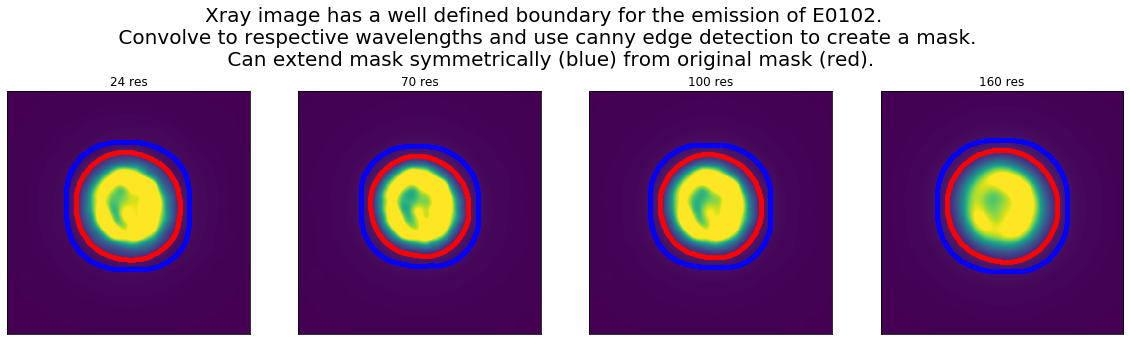

In [18]:
# Kernel and Xray File Handling
kernel_file = glob("Convolve_Regrid/Kernels/*.fits") 
xray_file = 'Original_Files/Xray/e0102_1100-2000eV.fits'
xray_kernel_files = [kernel_file[i] for i in [1,4,2,3]]
xray_kernels = [check_kernel(kernel) for kernel in xray_kernel_files]

# Middle two rows should be zero or there may be some rotation. 
xray_kernel_scales = np.array([fits.open(file)[0].header[key] for file in xray_kernel_files for key in  ['CD1_1','CD1_2','CD2_1','CD2_2'] ])

# The absolute value of CDELT1 and CDELT2 should be equal. 
xray_image_scale = np.abs(fits.open(xray_file)[0].header['CDELT1'])

# Scaling is xray image / kernel
xray_scale = xray_image_scale / xray_kernel_scales[0]

# Invert scaling to regrid
new_kernels = [check_kernel(scipy.ndimage.zoom(kernel, 1/xray_scale, order = 1)) for kernel in xray_kernels]

# Convolve
convolved_xray = [convolve_fft(fits.open(xray_file)[0].data,kernel,allow_huge=True) for kernel in new_kernels ]

# Detect Edges 
edges = [cv2.Canny(np.uint8(convolution),0,5) for convolution in convolved_xray]

# Get Edge Coordinates
ys,xs = [np.array(np.where(edge == 255) )[0] for edge in edges], [np.array(np.where(edge == 255) )[1] for edge in edges]

# Reduce Coordinates
masks = [mask_reduction(x,y) for x,y in zip(xs,ys)]

# Push Mask Out 
extend = 20
extend_masks = [extend_mask(extend,xs[i],ys[i],np.copy(masks[i][:,0]),np.copy(masks[i][:,1])) for i in range(4)]


# Convolved Xray Image with Mask
f, axes = plt.subplots(1,4,figsize=(20,6))
plt.suptitle("Xray image has a well defined boundary for the emission of E0102. \n Convolve to respective wavelengths and use canny edge detection to create a mask. \n Can extend mask symmetrically (blue) from original mask (red).",fontsize=20)
[axes[i].imshow(file, origin='lower',vmin=0,vmax=10) for i,file in enumerate(convolved_xray)]
[axes[i].set_title(title) for i,title in enumerate(['24 res','70 res','100 res','160 res'])];
[axes[i].scatter(masks[i][:,0],masks[i][:,1],c='r',s=10) for i in range(4)];
[axes[i].scatter(np.array(extend_masks[i])[0,:],np.array(extend_masks[i])[1,:],c='b',s=10) for i in range(4)];
[axes[i].tick_params(axis=u'both', which=u'both',length=0,labelleft="",labelbottom="") for i in range(4)];

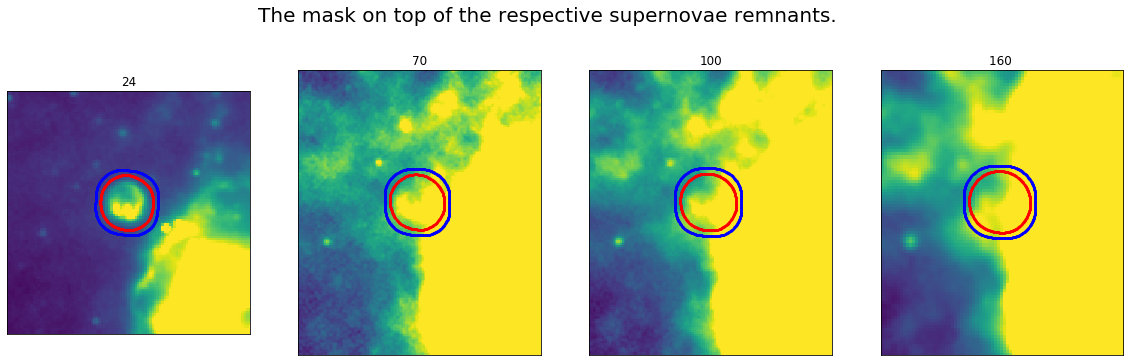

In [20]:
# Transform Mask Coordinates to Appropriate Infrared Image
mask_wcs = [to_world(xray_file,masks[i][:,0],masks[i][:,1]) for i in range(4)]
mask_pix = np.array([to_pix(infrared_file[i],np.array(mask_wcs[i])[0,:],np.array(mask_wcs[i])[1,:]) for i in range(4)])

extend_mask_wcs = [to_world(xray_file,np.array(extend_masks[i])[0,:],np.array(extend_masks[i])[1,:]) for i in range(4)]
extend_mask_pix = np.array([to_pix(infrared_file[i],np.array(extend_mask_wcs[i])[0,:],np.array(extend_mask_wcs[i])[1,:]) for i in range(4)])

# Infrared Mask Coordinates
f, axes = plt.subplots(1,4,figsize=(20,6))
plt.suptitle("The mask on top of the respective supernovae remnants.",fontsize=20)
[axes[i].imshow(fits.open(file)[0].data, origin='lower',vmin=np.min(d[i]),vmax=np.mean(d[i])) for i,file in enumerate(infrared_file)]
[axes[i].set_xlim(to_pix(file,ra,dec)[0]) for i,file in enumerate(infrared_file)]
[axes[i].set_ylim(to_pix(file,ra,dec)[1]) for i,file in enumerate(infrared_file)];
[axes[i].scatter(mask_pix[i][0],mask_pix[i][1],c="r",s=1) for i in range(4)];
[axes[i].scatter(extend_mask_pix[i][0],extend_mask_pix[i][1],c="b",s=1) for i in range(4)];
[axes[i].set_title(title) for i,title in enumerate(['24','70','100','160 '])];
[axes[i].tick_params(axis=u'both', which=u'both',length=0,labelleft="",labelbottom="") for i in range(4)];

## Background Removal

In [21]:
sub24, bkgd24 = diffusion_inpainting(extend_mask_pix[0][0],extend_mask_pix[0][1],fits.open(infrared_file[0])[0].data)
sub70, bkgd70 = diffusion_inpainting(extend_mask_pix[1][0],extend_mask_pix[1][1],fits.open(infrared_file[1])[0].data)

In [25]:
animation_name = "Diffuse24"
# Set up the animation
vmin,vmax = 0, 5

def animate(animation_name,vmin,vmax,sub,bkgd):
    f, axes = plt.subplots(1,2,figsize=(20,8))
    im_snr = axes[0].imshow(sub[0], vmin = vmin, vmax = vmax, animated=True, origin="lower");
    im_bkgd = axes[1].imshow(bkgd[0], vmin = vmin, vmax = vmax, animated=True, origin="lower");
    [ax.set_xlim(180,240) for ax in axes]
    [ax.set_ylim(120,180) for ax in axes]

    def run(i):
        im_snr.set_array(sub[i])
        im_bkgd.set_array(bkgd[i])

        return im_snr, im_bkgd


    plt.tight_layout()
    plt.close()

    # Write the animation out 
    ani = animation.FuncAnimation(f, run,np.arange(0,3000,5), blit=False, interval=200, repeat=True)
    ani.save('%s.gif' % animation_name,writer='imagemagick')

#ani.save('%s.mp4' % animation_name,writer='ffmpeg')
animate(animation_name,vmin,vmax,sub24,bkgd24)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


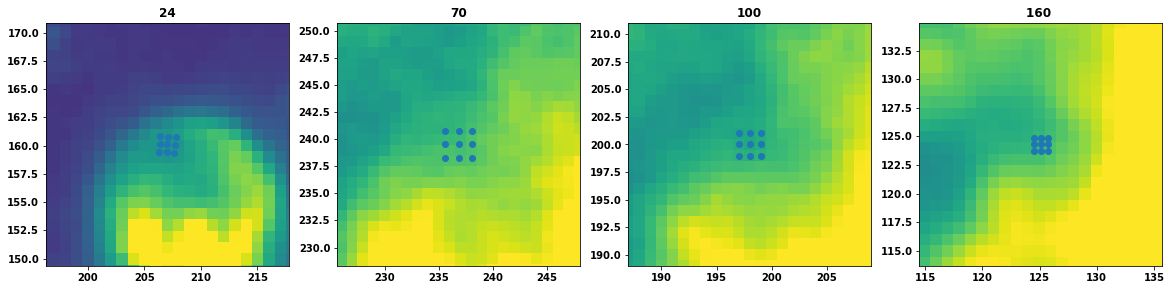

In [34]:
# We know this region is easily oversubtracted. It's the lowest point in the supernova. 
# The background removal shouldn't make this region negative if it's done right. 
null_ra,null_dec = np.loadtxt("Background_Removal/Bootstrap/NullRegionCoordinates.txt")
null_coords =  np.array([to_pix(infrared_file[i],null_ra,null_dec) for i in range(4)])

# Low Emission Region
f, axes = plt.subplots(1,4,figsize=(20,10))
n=10
[axes[i].imshow(fits.open(file)[0].data, origin='lower',vmin=np.min(d[i]),vmax=np.mean(d[i])) for i,file in enumerate(infrared_file)]
[axes[i].set_xlim(np.min(null_coords[i][0,:])-n,np.max(null_coords[i][0,:])+n) for i in range(4)]
[axes[i].set_ylim(np.min(null_coords[i][1,:])-n,np.max(null_coords[i][1,:])+n) for i in range(4)]
[axes[i].scatter(null_coords[i][0,:],null_coords[i][1,:]) for i in range(4)];
[axes[i].set_title(title) for i,title in enumerate(['24','70','100','160 '])];

In [11]:
animation_name = "Diffuse24"
# Set up the animation
vmin,vmax = 0, 5

f, axes = plt.subplots(1,2,figsize=(20,8))
im_snr = axes[0].imshow(sub[0], vmin = vmin, vmax = vmax, animated=True, origin="lower");
im_bkgd = axes[1].imshow(shell[0], vmin = vmin, vmax = vmax, animated=True, origin="lower");
[ax.set_xlim(180,240) for ax in axes]
[ax.set_ylim(120,180) for ax in axes]

def run(i):
    im_snr.set_array(sub[i])
    im_bkgd.set_array(shell[i])
    
    return im_snr, im_bkgd
    

plt.tight_layout()
plt.close()

# Write the animation out 
ani = animation.FuncAnimation(f, run,np.arange(0,3000,5), blit=False, interval=200, repeat=True)
#ani.save('%s.gif' % gifname,writer='imagemagick')

ani.save('%s.mp4' % animation_name,writer='ffmpeg')


In [12]:
Video("Diffuse24.mp4")

[(120, 180), (120, 180)]

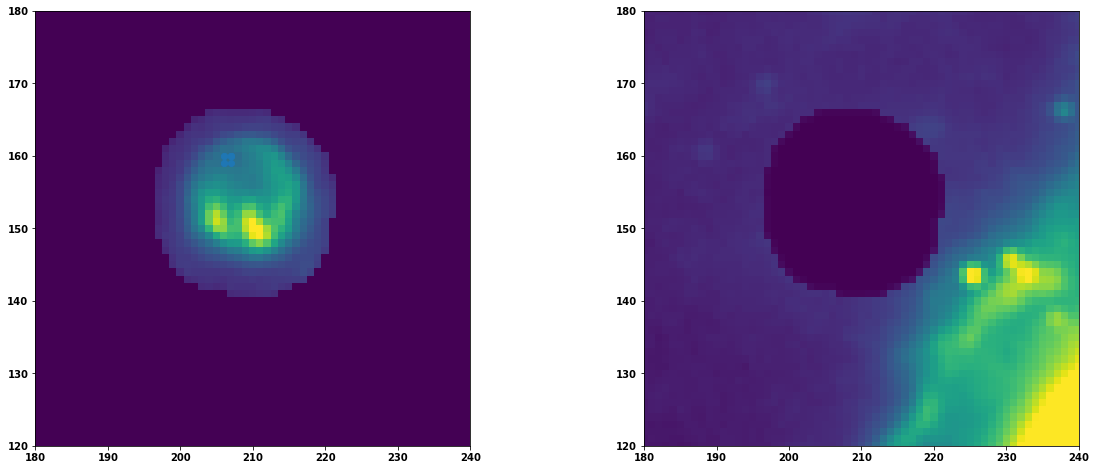

In [12]:
f, axes = plt.subplots(1,2,figsize=(20,8))
im_snr = axes[0].imshow(sub[0], vmin = vmin, vmax = vmax, animated=True, origin="lower");
im_bkgd = axes[1].imshow(shell[0], vmin = vmin, vmax = vmax, animated=True, origin="lower");
axes[0].scatter(null_coords[0][0,:].astype(int),null_coords[0][1,:].astype(int))
[ax.set_xlim(180,240) for ax in axes]
[ax.set_ylim(120,180) for ax in axes]


Text(0, 0.5, 'Mean Flux in Remnant Minimum [MJy sr$^{-1}$]')

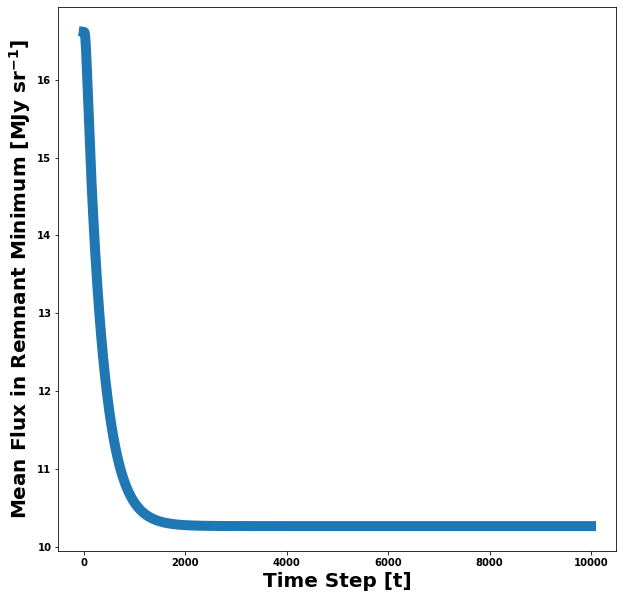

In [20]:
plt.figure(figsize=(10,10))
plt.plot([np.sum(subt[np.round(null_coords[0]).astype(int)[1,:],np.round(null_coords[0]).astype(int)[0,:]]) for subt in sub], linewidth=10 )
plt.xlabel('Time Step [t]', fontsize=20); plt.ylabel(r'Mean Flux in Remnant Minimum [MJy sr$^{-1}$]',fontsize=20)

# Handpick the most emission free region to get the noise from. 

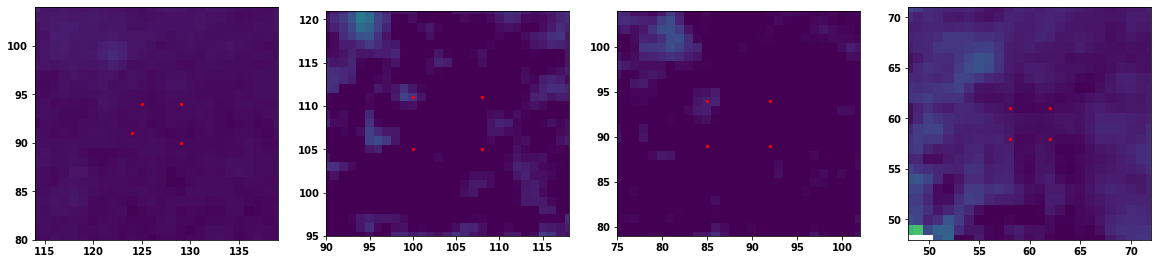

In [22]:
box_x, box_y = [100,100,108,108],[105,111,105,111]
box_ra, box_dec = to_world(infrared_file[1],box_x,box_y)
box_coords = [to_pix(file,box_ra,box_dec) for file in infrared_file] 

box_xs = [np.round(box_coords[i][0]).astype(int) for i in range(4)]
box_ys = [np.round(box_coords[i][1]).astype(int) for i in range(4)]

min_region = [fits.open(file)[0].data[min(box_ys[i]):max(box_ys[i]),min(box_xs[i]):max(box_xs[i])] for i,file in enumerate(infrared_file)]
#,np.round(box_coords[i][1]).astype(int),s=5,c='r')
f, axes = plt.subplots(1,4,figsize=(20,10))
n=10
[axes[i].imshow(fits.open(file)[0].data, origin='lower',vmin=np.min(d[i]),vmax=np.mean(d[i])) for i,file in enumerate(infrared_file)]
[axes[i].scatter(box_xs[i],box_ys[i],s=5,c='r') for i in range(4)]
[axes[i].set_xlim(min(box_xs[i])-10,max(box_xs[i])+10) for i in range(4)]
[axes[i].set_ylim(min(box_ys[i])-10,max(box_ys[i])+10) for i in range(4)];


In [23]:
[np.mean(min_region[i]) for i in range(4)]

[0.14500085, -10.212364531374874, -12.964180688663225, 1.3763948957583747]

In [32]:
to_world(infrared_file[1],[100,100,108,108],[105,111,105,111])

[array([16.18770124, 16.18767882, 16.17759042, 16.17756928]),
 array([-72.07933039, -72.07699707, -72.07933933, -72.07700601])]

In [39]:
to_pix(infrared_file[0],[16.18770124, 16.18767882, 16.17759042, 16.17756928],[-72.07933039, -72.07699707, -72.07933933, -72.07700601])[0]

array([124.25711512, 124.5254377 , 128.74464097, 129.01296498])

C:\Users\Betha\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Betha\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


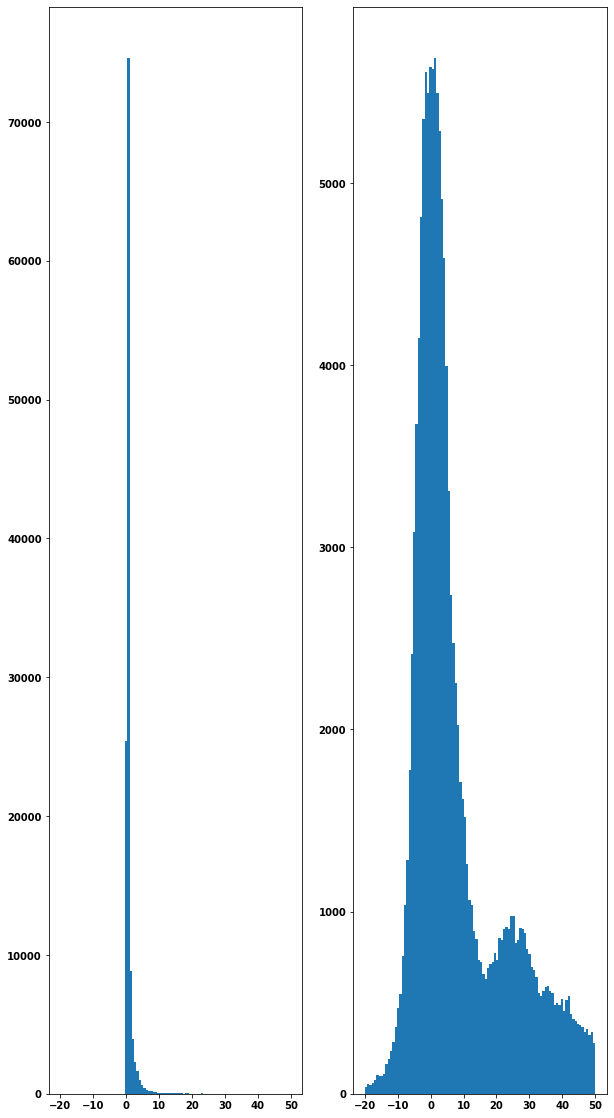

In [14]:
f, (ax,bx) = plt.subplots(1,2,figsize=(10,20))
ax.hist(fits.open(infrared_file[0])[0].data.ravel(),bins=100,range=[-20,50]);
bx.hist(fits.open(infrared_file[1])[0].data.ravel(),bins=100,range=[-20,50]);